In [1]:
from __future__ import print_function, division, absolute_import
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import rc
from scipy.signal import spectrogram

#plt.style.use('dark_background')
rc('font', size=30)
rc('legend', fontsize=22)
rc('xtick', labelsize=24)

In [4]:
from skreflectometry.mode_O import refraction_index_O, refractive_matrix_O, cutoff_freq_O, abel_inversion, CalcInvPerfO
from skreflectometry.mode_X import refraction_index_X, refractive_matrix_X, cutoff_freq_X
from skreflectometry.physics import cyclotron_frequency, plasma_frequency, cyclotron_field, plasma_density, upper_hybrid_frequency, distance_vacuum
#from SimulateGroupDelayDispersive import create_density, create_ne_drop
from skreflectometry.data_generation import density_profile, density_add_bump, magnetic_field_profile
from skreflectometry.reflectometry_sim import phase_delay, group_delay, beat_signal, beat_maximums
from skreflectometry.graphs import plot_refractive_matrix

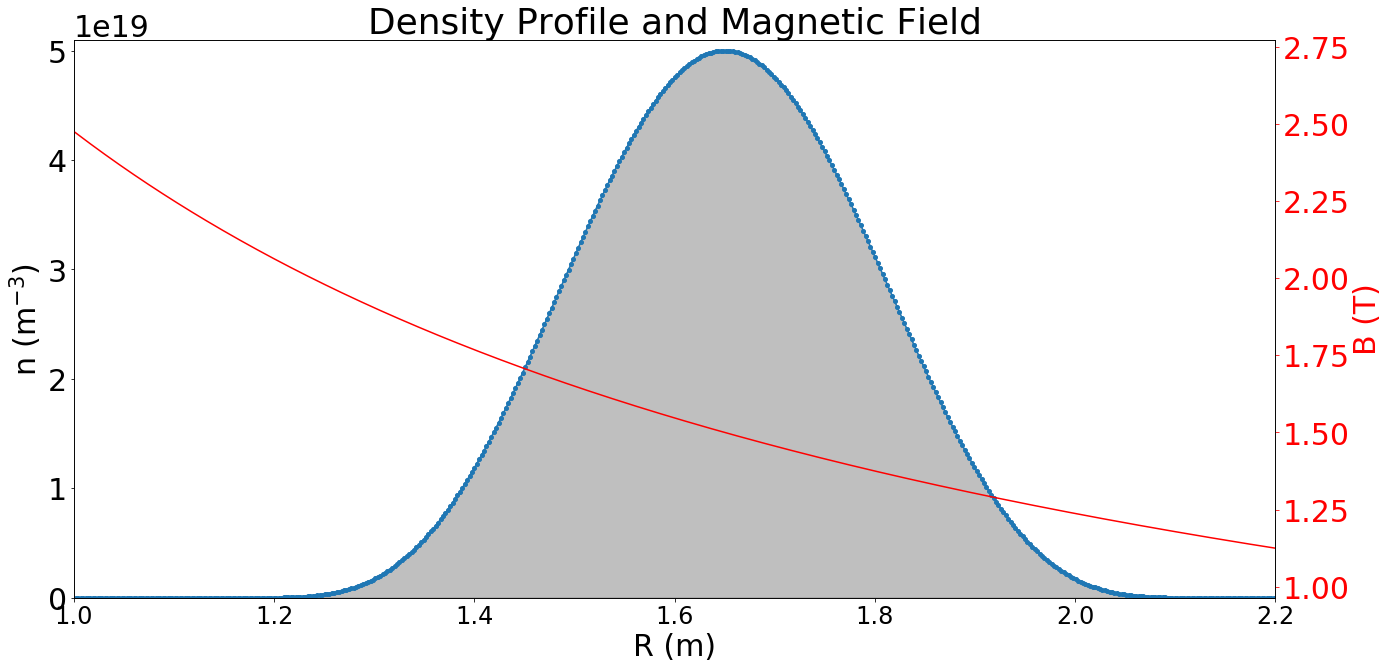

In [103]:
plt.figure(figsize=(20, 10))

# plt.subplot(1, 2, 1)
radius_arr, dens_prof = density_profile(n_points=600)
#dens_prof = density_add_bump(radius_arr, dens_prof, bump_pos=1.5, bump_size=0.2, bump_height=0.5)
# plt.plot(radius_arr, dens_prof, '-o', lw=2)
# plt.fill_between(radius_arr, dens_prof, 0.0, color='k', alpha=0.25)

# plt.xlabel('R (m)')
# plt.ylabel('n (m$^{-3}$)')
# plt.title('Density Profile for O-Mode')

# plt.xlim(1.0, 2.2)
# plt.ylim(0, 5.1e19)

###

# ax1 = plt.subplot(1, 2, 2)
ax1 = plt.gca()
rs, ns = density_profile(radius_arr=np.linspace(2.15, 2.1, 600), m=30, n=3, dens_central=10e19, r_vacuum=0.002)
rs, ns = density_profile(n_points=600)
bs = magnetic_field_profile(rs, mag_field_ref=1.5, pos_ref=1.65)
#rs = rs[0] - rs
#ns = density_add_bump(rs, ns, bump_pos=0.02, bump_size=0.001, bump_height=.95*.95)
plt.plot(rs, ns, '-o', markersize=4)
plt.fill_between(rs, ns, 0.0, color='k', alpha=0.25)

plt.xlabel('R (m)')
plt.ylabel('n (m$^{-3}$)')
plt.title('Density Profile and Magnetic Field')

#plt.xlim(0, 0.05)
plt.xlim(1.0, 2.2)
plt.ylim(0, 5.1e19)

ax2 = ax1.twinx()
ax2.plot(rs, bs, 'r-')
ax2.set_ylabel('B (T)', color='r')
ax2.tick_params('y', colors='r')

plt.tight_layout()
plt.savefig('images/density_profiles.png', dpi=200)
plt.show()

In [104]:
f_sampling = 125e6
sweep_time = 25e-6
n_points_fs = int(sweep_time * f_sampling)

fs_O_limits = np.array([1, 1e11])
sweep_rate = np.abs(np.diff(fs_O_limits)) / sweep_time

f_sampling_X = 1e6
sweep_time = 25e-6
n_points_fs_X = int(sweep_time * f_sampling_X) * 100
# fs_X_limits = np.array([40e9, 100e9])
fs_X_limits = np.array([1, 100e9])
sweep_rate_X = np.abs(np.diff(fs_X_limits)) / sweep_time

### Calcs ###

#fs_O = np.sort(np.hstack([np.logspace(0, 11, 500), np.linspace(1, 1e11, 500)]))
fs_O = np.linspace(fs_O_limits[0], fs_O_limits[1], n_points_fs)
fs_X = np.linspace(fs_X_limits[0], fs_X_limits[1], n_points_fs_X)
#fs_X = np.linspace(40e9, 100e9, 500)

n_index_O = refractive_matrix_O(dens_prof, fs_O)
n_index_X = refractive_matrix_X(ns, fs_X, mag_field=bs)

n_index_O_sq = refractive_matrix_O(dens_prof, fs_O, squared=True)
n_index_X_sq = refractive_matrix_X(ns, fs_X, mag_field=bs, squared=True)

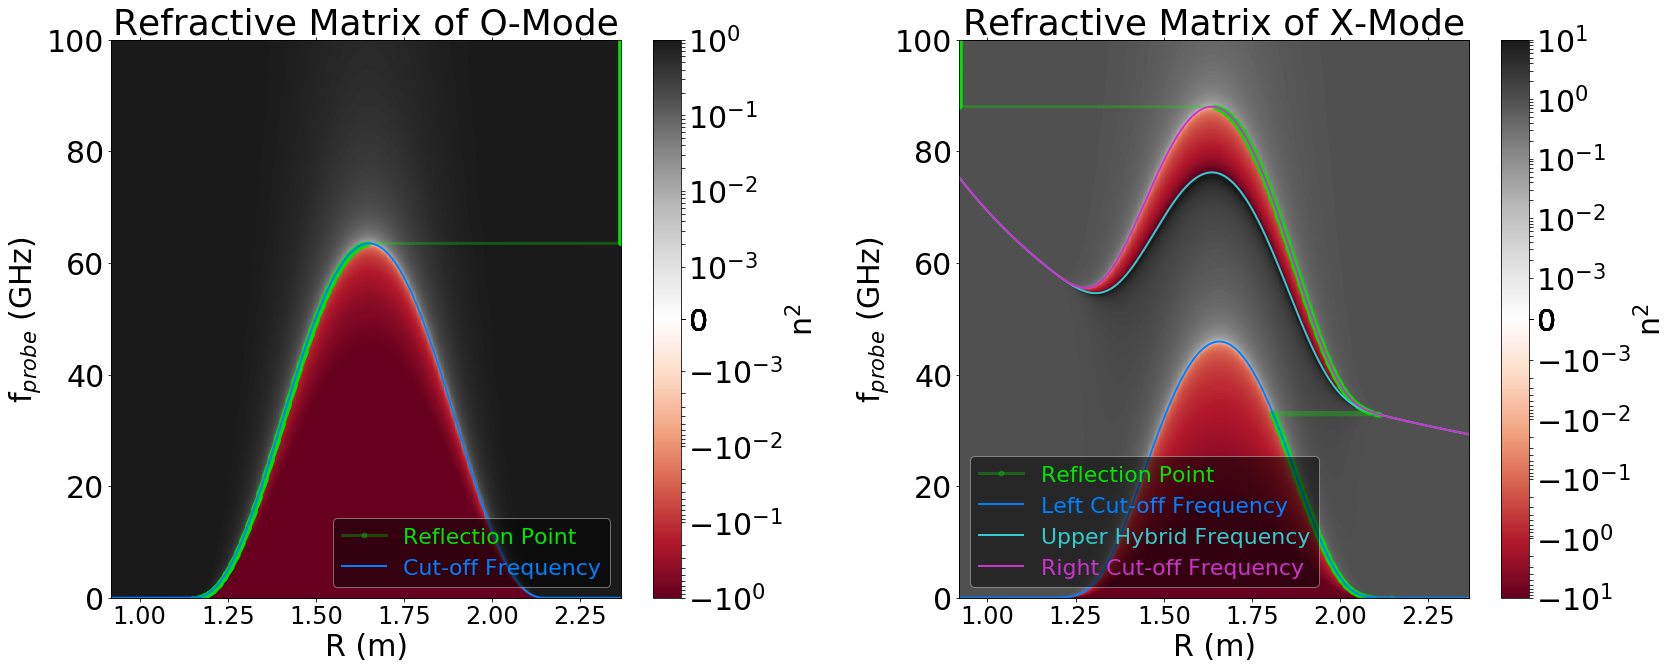

In [115]:
plt.figure(figsize=(24, 10))

ax_O = plt.subplot(1, 2, 1)
    
plot_refractive_matrix(radius_arr, dens_prof, fs_O, n_index_O_sq, axis=ax_O, wave_mode='O', legend_loc='lower right', title='O-Mode')

ax_X = plt.subplot(1, 2, 2)
    
plot_refractive_matrix(rs, ns, fs_X, n_index_X_sq, axis=ax_X, mag_field=bs, wave_mode='X', antenna_side='lfs', legend_loc='lower left', title='X-Mode',
                       norm=colors.SymLogNorm(linthresh=1e-3, clip=True, vmin=-10, vmax=10))

plt.tight_layout()
plt.savefig('images/refractive_matrixes.png', dpi=200)
plt.show()

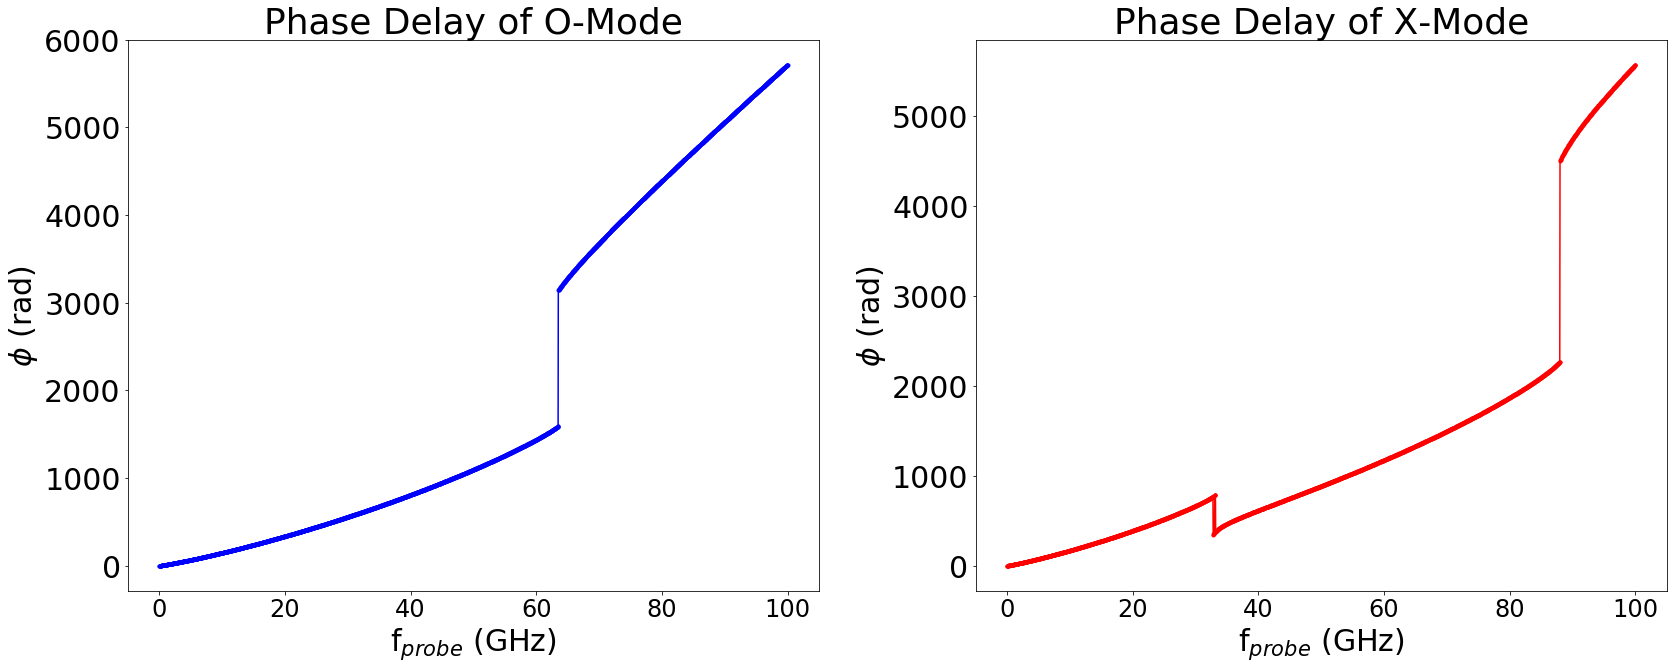

In [107]:
phi_O = phase_delay(fs_O, radius_arr, n_index_O, reflect_at_wall=True)
phi_X = phase_delay(fs_X, rs, n_index_X, refract_epsilon=1e-6, antenna_side='lfs')

plt.figure(figsize=(24, 10))

plt.subplot(1, 2, 1)

plt.plot(fs_O/1e9, phi_O, 'b.-')

plt.title('Phase Delay of O-Mode')
plt.xlabel('f$_{probe}$ (GHz)')
plt.ylabel('$\phi$ (rad)')

plt.subplot(1, 2, 2)

plt.plot(fs_X/1e9, phi_X, 'r.-')

plt.title('Phase Delay of X-Mode')
plt.xlabel('f$_{probe}$ (GHz)')
plt.ylabel('$\phi$ (rad)')

plt.tight_layout()
plt.savefig('images/phase_delays.png', dpi=200)
plt.show()

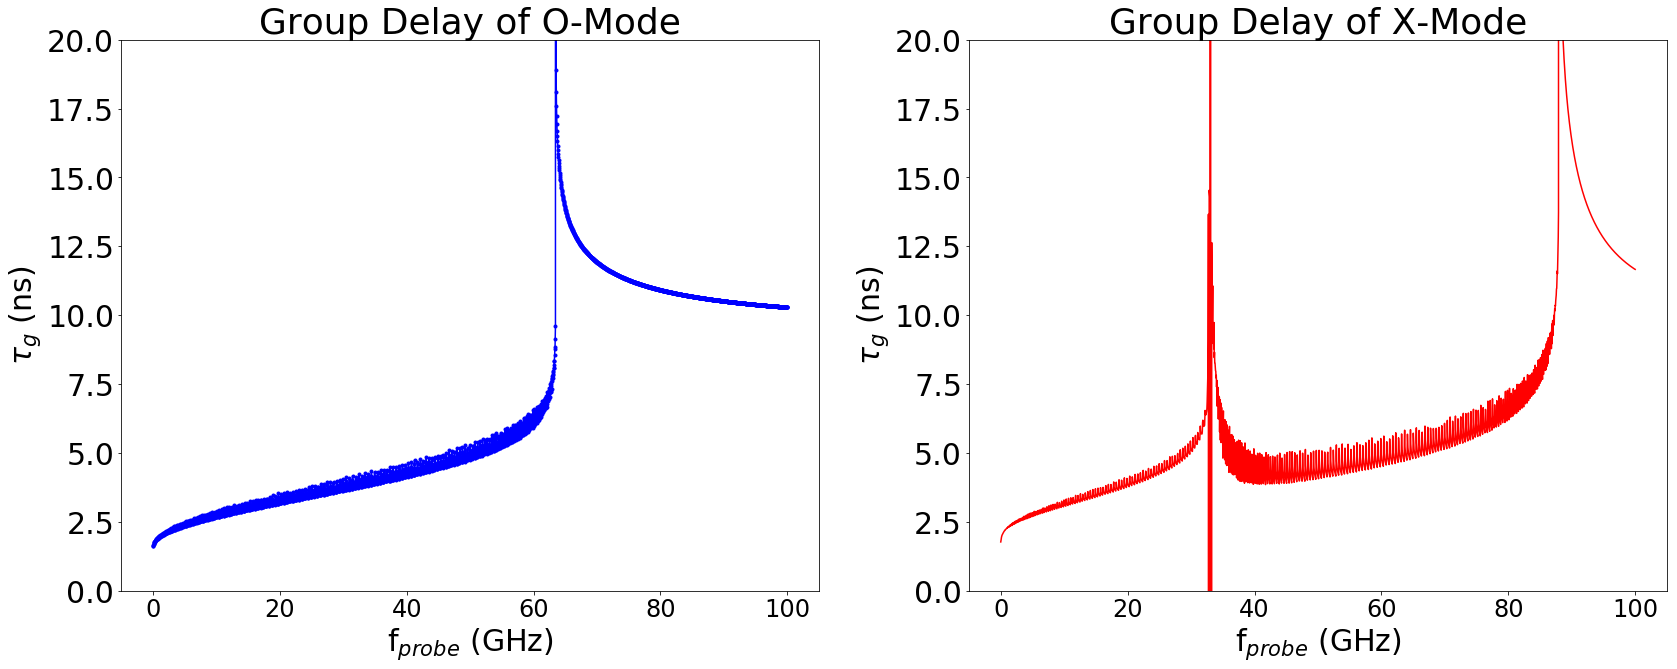

In [108]:
delta_t_O = group_delay(fs_O, phi_O)
delta_t_X = group_delay(fs_X, phi_X)

plt.figure(figsize=(24, 10))

plt.subplot(1, 2, 1)

plt.plot(fs_O/1e9, delta_t_O*1e9, 'b.-')

plt.title('Group Delay of O-Mode')
plt.xlabel('f$_{probe}$ (GHz)')
plt.ylabel(r'$\tau_g$ (ns)')

plt.ylim(0, 20)

plt.subplot(1, 2, 2)

plt.plot(fs_X/1e9, delta_t_X*1e9, 'r-')

plt.title('Group Delay of X-Mode')
plt.xlabel('f$_{probe}$ (GHz)')
plt.ylabel(r'$\tau_g$ (ns)')

plt.ylim(0, 20)

plt.tight_layout()
plt.savefig('images/group_delays.png', dpi=200)
plt.show()

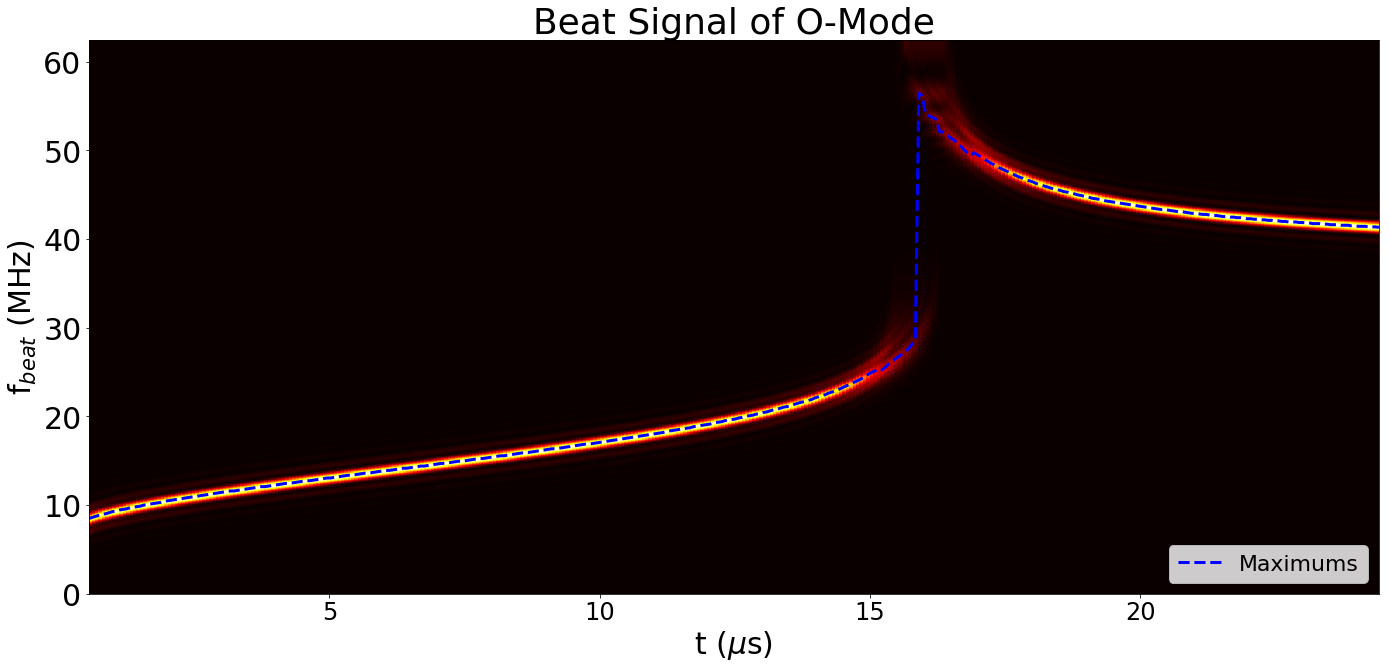

In [102]:
beat_sig = beat_signal(fs_O, delta_t_O)
beat_sig_X = beat_signal(fs_X, delta_t_X)

fs, ts, spectrum = spectrogram(beat_sig, fs=f_sampling, nperseg=136, nfft=2048, noverlap=128)
beat_max = beat_maximums(fs, spectrum)

fsamp_X, ts_X, spectrum_X = spectrogram(beat_sig_X, fs=f_sampling_X, nperseg=128+64, nfft=2048, noverlap=128)
beat_max_X = beat_maximums(fsamp_X, spectrum_X)

delta_t_noise = beat_max / sweep_rate
fs_noise = ts * sweep_rate

plt.figure(figsize=(20, 10))

# plt.subplot(1, 2, 1)

plt.pcolormesh(ts*1e6, fs*1e-6, spectrum, cmap='hot')
plt.plot(ts*1e6, beat_max*1e-6, '--', color=(0,0,1), lw=3, label='Maximums')

plt.ylim(0, f_sampling/2e6)

plt.xlabel('t ($\mu$s)')
plt.ylabel('f$_{beat}$ (MHz)')
plt.title('Beat Signal of O-Mode')

plt.legend(loc='lower right')

# plt.subplot(1, 2, 2)

# plt.pcolormesh(ts_X*1e6, fsamp_X*1e-6, spectrum_X, cmap='hot')
# plt.plot(ts_X*1e6, beat_max_X*1e-6, '--', color=(0,0,1))

#plt.ylim(0, 4)

# plt.xlabel('t ($\mu$s)')
# plt.ylabel('f$_{beat}$ (MHz)')

plt.tight_layout()
plt.savefig('images/spectrogram.png', dpi=200)
plt.show()

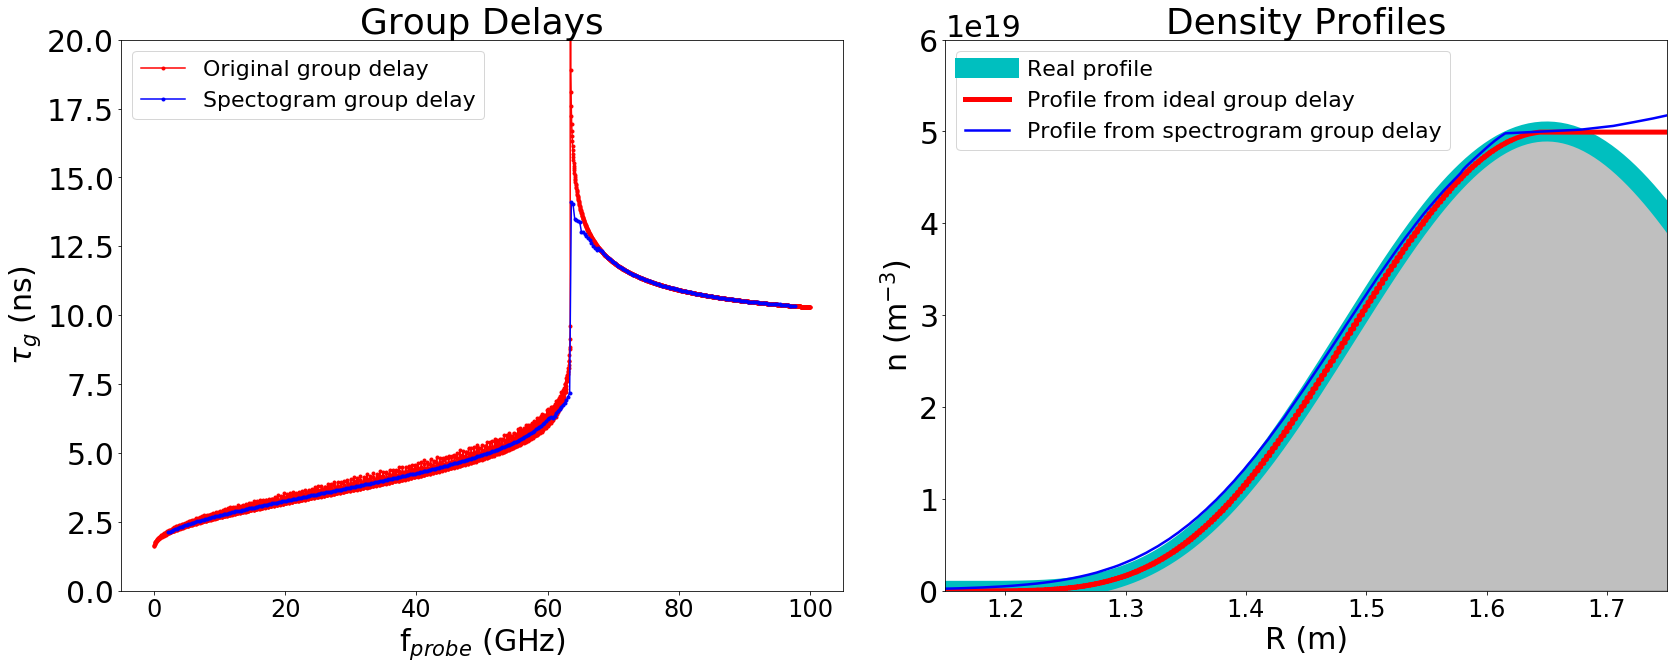

In [99]:
radius_calc, dens_arr_to_calc = abel_inversion(fs_O, delta_t_O, pos_antenna=radius_arr[0]+.015, other_method=False)
radius_calc_other, dens_arr_to_calc_other = abel_inversion(fs_O, delta_t_O, pos_antenna=radius_arr[0], other_method=True)
radius_noise, dens_noise = abel_inversion(fs_noise, delta_t_noise, pos_antenna=radius_arr[0], other_method=True)

plt.figure(figsize=(24, 10))

plt.subplot(1, 2, 1)

plt.plot(fs_O*1e-9, delta_t_O*1e9, 'r.-', label='Original group delay')
plt.plot(fs_noise*1e-9, delta_t_noise*1e9, 'b.-', label='Spectogram group delay')

plt.title('Group Delays')
plt.xlabel('f$_{probe}$ (GHz)')
plt.ylabel(r'$\tau_g$ (ns)')

plt.ylim(0, 20)

plt.legend(loc='upper left')

plt.subplot(1, 2, 2)

plt.plot(radius_arr, dens_prof, 'c-', label='Real profile', lw=20)
plt.fill_between(radius_arr, dens_prof, 0.0, color='k', alpha=0.25)
#plt.plot(radius_calc, dens_arr_to_calc, 'm-', label='from delta_t (integral)')
plt.plot(radius_calc_other, dens_arr_to_calc_other, 'r-', lw=5, label='Profile from ideal group delay')
plt.plot(radius_noise, dens_noise, 'b-', lw=2.5, label="Profile from spectrogram group delay")

plt.xlim(1.15, 1.75)
plt.ylim(0, 6e19)

plt.xlabel('R (m)')
plt.ylabel('n (m$^{-3}$)')
plt.title('Density Profiles')

plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('images/reconstruction.png', dpi=200)
plt.show()